In [1]:
import numpy as np
from numpy.random import normal as GaussianDistribution
import matplotlib.pyplot as plt
import os

In [2]:
%matplotlib inline

reference git: https://github.com/brianfarris/RLtalk/blob/master/RLtalk.ipynb

In [13]:
class Bandit:
    def __init__(self, arm_vals = []):
        # If arm values not provided generate random values between [0,1] of length 10
        if arm_vals == []:
            self.arm_values = np.random.normal(0,1,10) # actual mean value of actions # mean reward
        else:
            self.arm_values = arm_vals
        
        self.k = len(self.arm_values)
        self.K = np.zeros(self.k) # number of actions
        self.est_values = np.zeros(self.k) # estimated value of value of actions
        

    def get_reward(self,action):
        reward = GaussianDistribution(loc=self.arm_values[action], scale=1, size=1)[0]
        return reward
    
    def choose_eps_greedy(self,epsilon):
        rand_num = np.random.random()
        if epsilon>rand_num:
            return np.random.randint(self.k) # Exploring # selecting random k value
        else:
            return np.argmax(self.est_values) # Exploiting # select action k with highest reward

    
    def update_est(self,action,reward,alpha = None):
        self.K[action] += 1
        if alpha == None:
            alpha = 1./self.K[action]
        self.est_values[action] += alpha * (reward - self.est_values[action]) 
        # Updating the estimate value with the mean value of rewards
        # keeps running average of rewards

    def isoptimal(self,action):
        if action == np.argmax(self.arm_values):
            return True
        else:
            return False

    def update_arm_vals(self,pull):
        # Adding non stationarity
        # changing the value of arm values with time
        random_walk = GaussianDistribution(loc=0, scale=0.01, size=self.k)
        self.arm_values += random_walk

        # for i in range(len(self.arm_values)):
        #     self.arm_values[i] += np.random.normal(0,0.1)


## Stationary problem

In [84]:
def run_experiment(bandit, Npulls=1000, epsilon=0.01, alpha=None):
    history = []
    correct_pct = []
    ct = 0


    for i in range(Npulls):
        action = bandit.choose_eps_greedy(epsilon) 

        # % selection of correct action
        if bandit.isoptimal(action):
            ct += 1
            correct_pct.append(ct*100/Npulls)
        else:
            correct_pct.append(ct*100/Npulls)

        R = bandit.get_reward(action)
        bandit.update_est(action, R, alpha)
        history.append(R)
    return {'Qa': np.array(history) , 'correctness': correct_pct}


In [89]:
def run_simulation(Nexp=20, Npulls=1000, epsilons=[0.05], 
                    bandit_args={'arm_vals' : [], 'alpha' : None}, experiment=run_experiment):
    
    avg_reward = {}
    avg_correctness = {}

    for epsilon in epsilons:
        avg_reward[str(epsilon)]  = np.zeros(Npulls)
        avg_correctness[str(epsilon)] = np.zeros(Npulls)

        for i in range(Nexp):
            bandit = Bandit(bandit_args['arm_vals'])
            result = experiment(bandit, Npulls, epsilon, bandit_args['alpha'])
            
            avg_reward[str(epsilon)]  += result['Qa']
            avg_correctness[str(epsilon)]  += result['correctness']
        
        avg_reward[str(epsilon)] /= np.float(Nexp)
        avg_correctness[str(epsilon)] /= np.float(Nexp)
    
    os.system('say "Done compiling"')

    return (avg_reward,avg_correctness)

In [90]:
def plotting(dictn, xlabel = 'Npulls', ylabel = 'Reward', ylim = (None,None)):

    for eps in dictn:
        plt.plot(dictn[eps],label="eps = {}".format(eps))
    
    if ylim[0] != None or ylim[1] != None:    
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [91]:
## Stationary problems with 3 different epsilon values
avg_reward, avg_correctness = run_simulation(Nexp = 500,Npulls = 3000, epsilons = [0.0,0.01,0.1],
                                bandit_args={'arm_vals' : [] , 'alpha' : None})

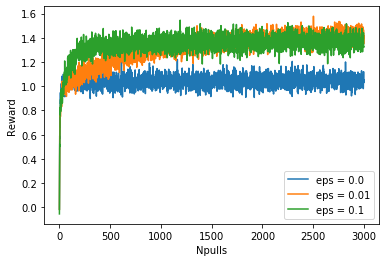

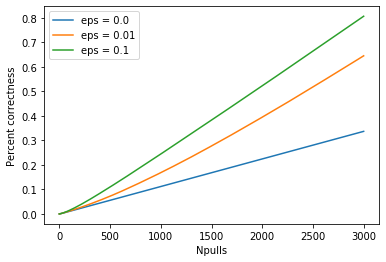

(None, None)

In [92]:
plotting(avg_reward), plotting(avg_correctness,ylabel= 'Percent correctness')

In [36]:
# Predefined average arm values
# kav - known arm values
avg_reward_kav , avg_correctness_kav = run_simulation(Nexp = 500,Npulls = 3000, epsilons = [0.0,0.01,0.1],
                                bandit_args={'arm_vals' : [1.2,-1.1,1.8,10,-1.33,1.42,-1.5] , 'alpha' : None})

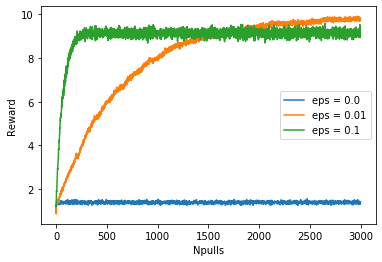

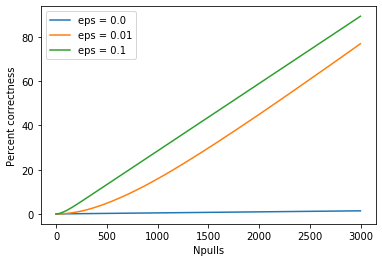

(None, None)

In [93]:
plotting(avg_reward_kav), plotting(avg_correctness_kav,ylabel= 'Percent correctness')

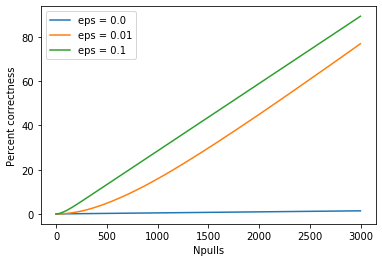

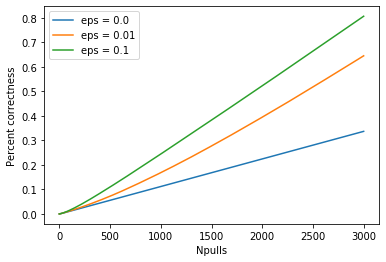

(None, None)

In [94]:
plotting(avg_correctness_kav,ylabel= 'Percent correctness'), plotting(avg_correctness,ylabel= 'Percent correctness') 

## Non stationary problem

In [60]:
def run_experiment_ns(bandit, Npulls=1000, epsilon=0.01, alpha= []):
    history = []
    correct_pct = []
    ct = 0
   
    # print(optimal_action)

    for i in range(Npulls):
        action = bandit.choose_eps_greedy(epsilon) 
        # % selection of correct action
    
        if bandit.isoptimal(action):
            ct += 1
            correct_pct.append(ct*100/Npulls)
        else:
            correct_pct.append(ct*100/Npulls)

        R = bandit.get_reward(action)
        bandit.update_est(action, R, alpha) 
        bandit.update_arm_vals(i)
        history.append(R)

    return {'Qa' : np.array(history), 'correctness' : np.array(correct_pct)}

In [75]:
avg_reward_ns , avg_correctness_ns = run_simulation(Nexp = 500,Npulls = 3000, epsilons = [0.0,0.01,0.1],
                                bandit_args={'arm_vals' : [1.2,-1.1,1.8,10,-1.33,1.42,-1.5] , 'alpha' : None},
                                experiment=run_experiment_ns) 

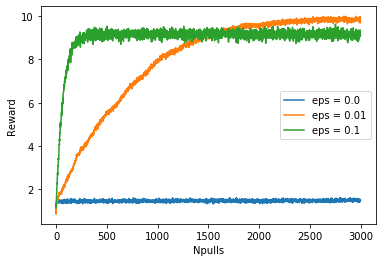

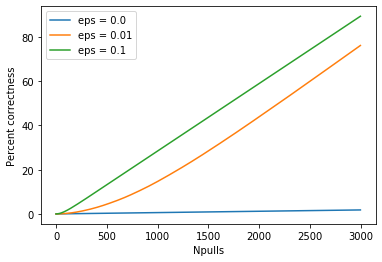

(None, None)

In [95]:
plotting(avg_reward_ns), plotting(avg_correctness_ns,ylabel= 'Percent correctness') 

## Exponential recency-weighted average.

In [105]:
avg_reward_ns_alpha , avg_correctness_ns_alpha = run_simulation(Nexp = 500,Npulls = 3000, epsilons = [0.0,0.01,0.1],
                                bandit_args={'arm_vals' : [1.2,-1.1,1.8,10,-1.33,1.42,-1.5] , 'alpha' : 0.1},
                                experiment=run_experiment_ns)      

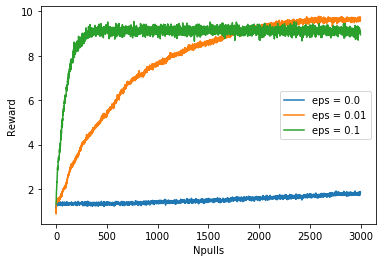

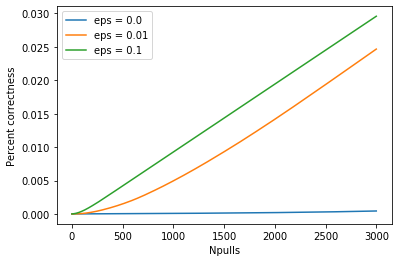

(None, None)

In [106]:
plotting(avg_reward_ns_alpha), plotting(avg_correctness_ns_alpha,ylabel= 'Percent correctness')

## Exercise 2.5

In [61]:
avg_reward_ns_alpha25 , avg_correctness_ns_alpha25 = run_simulation(Nexp = 500, Npulls = 10000,
                                                     epsilons = [0.1], 
                                                     bandit_args={'arm_vals' : [5,5,5,5,5,5,5,5],'alpha' : 0.1},                                                          experiment=run_experiment_ns) 

In [63]:
avg_reward25_ns , avg_correctness25_ns =  run_simulation(Nexp = 500, Npulls = 10000, 
                                                    epsilons = [0.1], 
                                                    bandit_args={'arm_vals' : [5,5,5,5,5,5,5,5],'alpha': None},                                                          experiment=run_experiment_ns) 

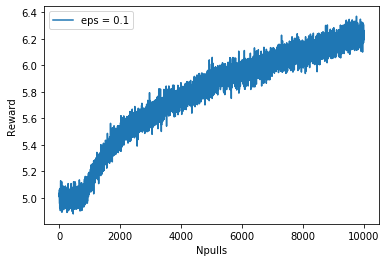

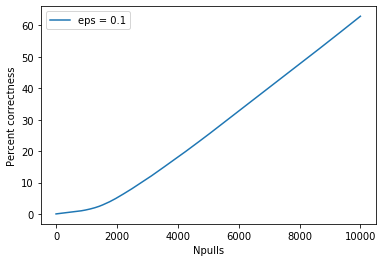

(None, None)

In [98]:
plotting(avg_reward_ns_alpha25), plotting(avg_correctness_ns_alpha25,ylabel= 'Percent correctness')

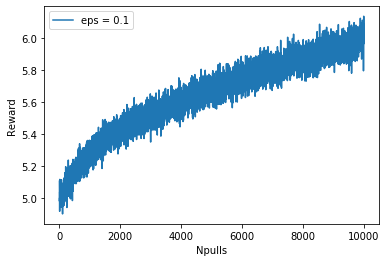

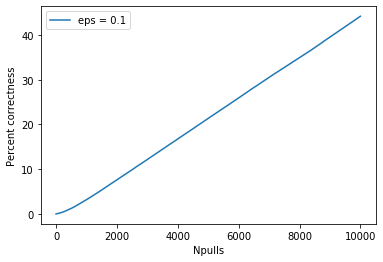

(None, None)

In [99]:
plotting(avg_reward25_ns), plotting(avg_correctness25_ns,ylabel= 'Percent correctness')

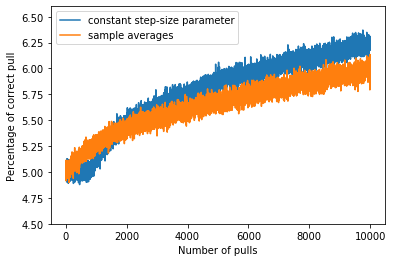

In [103]:
plt.plot(avg_reward_ns_alpha25['0.1'],label="constant step-size parameter")
plt.plot(avg_reward25_ns['0.1'],label="sample averages")
plt.ylim(4.5,6.6)
plt.legend()
plt.ylabel('Percentage of correct pull')
plt.xlabel('Number of pulls')
plt.show()

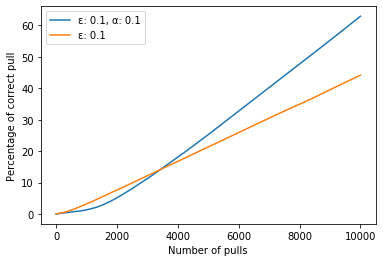

In [104]:
plt.plot(avg_correctness_ns_alpha25['0.1'],label="\u03B5: 0.1, \u03B1: 0.1")
plt.plot(avg_correctness25_ns['0.1'],label="\u03B5: 0.1")
plt.legend()
plt.ylabel('Percentage of correct pull')
plt.xlabel('Number of pulls')
plt.show()

## Optimal Intial Value